In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from uav_active_sensing.config import EXTERNAL_DATA_DIR
from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import ImageExplorationEnv, RewardFunction, ImageExplorationEnvConfig
from uav_active_sensing.plots import visualize_tensor, visualize_act_mae_reconstruction, visualize_mae_reconstruction
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor, ViTMAEForPreTraining


2025-02-28 13:14:26.736 | INFO     | uav_active_sensing.config:<module>:14 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing
2025-02-28 13:14:26.737 | INFO     | uav_active_sensing.config:<module>:49 - Using device: cpu


In [3]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)  # TODO: Download this in advance
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)

## Reconstruct image with trained autoencoder

In [4]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

In [5]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [6]:
mae_model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAESdpaAttention(
            (attention): ViTMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=

In [7]:
# From: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb

imagenet_mean = np.array(image_processor.image_mean)
imagenet_std = np.array(image_processor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model, outputs):
  
  y = model.unpatchify(outputs.logits)
  y = torch.einsum('nchw->nhwc', y).detach().cpu()
  
  # visualize the mask
  mask = outputs.mask.detach()
  mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
  mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
  mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
  
  x = torch.einsum('nchw->nhwc', pixel_values)

  # masked image
  im_masked = x * (1 - mask)

  # MAE reconstruction pasted with visible patches
  im_paste = x * (1 - mask) + y * mask

  # make the plt figure larger
  plt.rcParams['figure.figsize'] = [24, 24]

  plt.subplot(1, 4, 1)
  show_image(x[0], "original")

  plt.subplot(1, 4, 2)
  show_image(im_masked[0], "masked")

  plt.subplot(1, 4, 3)
  show_image(y[0], "reconstruction")

  plt.subplot(1, 4, 4)
  show_image(im_paste[0], "reconstruction + visible")

  plt.show()

### Inputs

In [8]:
image, _ = tiny_imagenet_train_dataset[6548]
# inputs = image_processor(images=image, return_tensors="pt")


### Standard masking strategy

/tmp/ipykernel_31958/2427510520.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


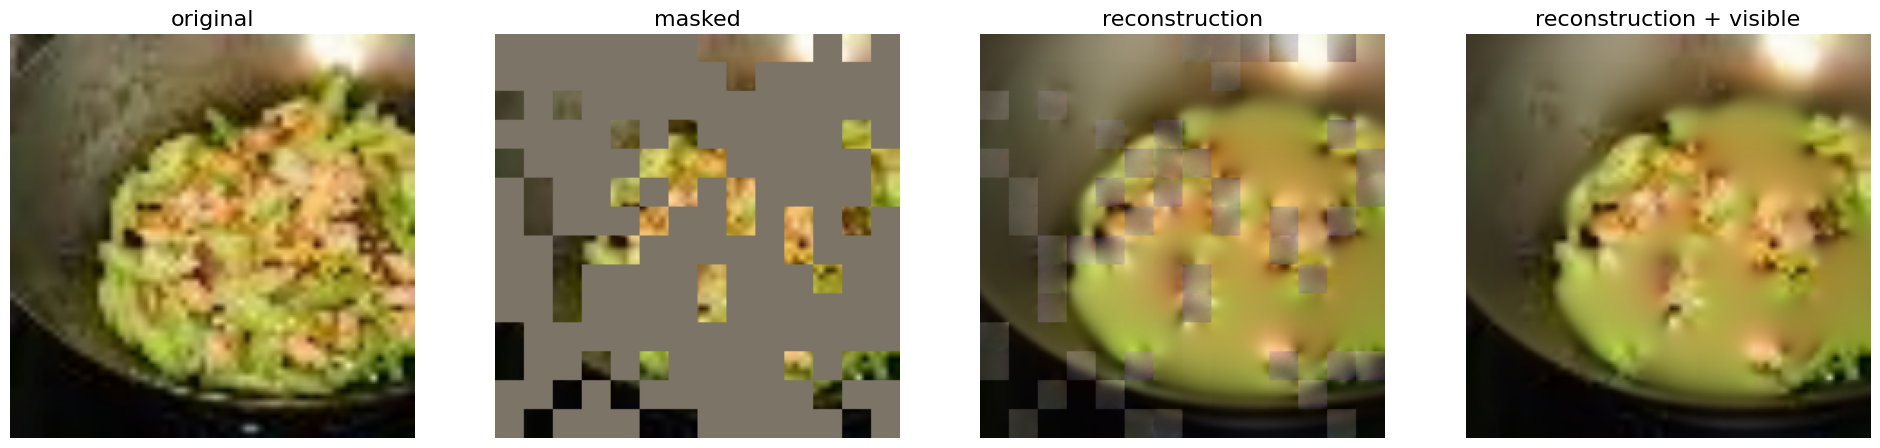

In [9]:
pretrained_outputs = mae_model(**image)
visualize(image.pixel_values, mae_model, pretrained_outputs)

In [10]:
vars(pretrained_outputs)

{'loss': tensor(0.1892, grad_fn=<DivBackward0>),
 'logits': tensor([[[-1.0781, -1.0526, -1.1131,  ..., -0.8072, -0.8145, -0.9179],
          [-0.8274, -0.8187, -0.9340,  ..., -0.3963, -0.3608, -0.5353],
          [-0.5278, -0.5198, -0.6757,  ..., -0.0257, -0.0200, -0.2493],
          ...,
          [-1.8085, -1.7792, -1.7635,  ..., -1.9952, -1.8699, -1.5436],
          [-1.1925, -1.3290, -1.3048,  ..., -1.4527, -1.2828, -1.1232],
          [-1.8366, -1.8261, -1.6456,  ..., -1.9345, -1.8134, -1.6659]]],
        grad_fn=<SliceBackward0>),
 'mask': tensor([[1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
          0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
          1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
          1., 1., 0., 1., 0., 1., 0., 1

### Custom masking strategy

In [12]:
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization
act_mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(act_mae_model)
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)

env.reset()
for j in range(50):
    sample_action = env.action_space.sample()
    env.step(sample_action)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


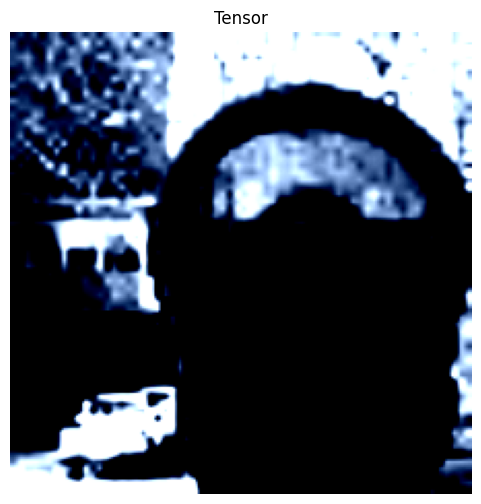

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..1.8905447].


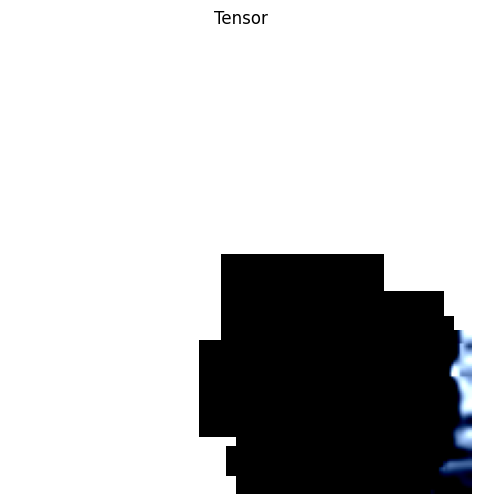

In [13]:
visualize_tensor(env.img)
visualize_tensor(env.sampled_img)

In [14]:
visualize_mae_reconstruction(env.img, mae_model, show=False, save_path="test_mae_reconstruction")
visualize_act_mae_reconstruction(env.img, env.sampled_img, act_mae_model, show=False, save_path="test_act_mae_reconstruction")

